In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os

dataset_root = '/content/drive/MyDrive/dataset/train'

class_labels = os.listdir(dataset_root)

print("Class labels:",class_labels)

Class labels: ['Healthy', 'Gingivitis', 'Tooth-Discoloration', 'Mouth-Ulcer', 'Data-caries']


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/drive/MyDrive/dataset/train", batch_size=32, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/drive/MyDrive/dataset/test", batch_size=32, target_size=(224,224))
vldata = ImageDataGenerator()
validatedata = vldata.flow_from_directory(directory="/content/drive/MyDrive/dataset/validation", batch_size=32, target_size=(224,224))

Found 9019 images belonging to 5 classes.
Found 314 images belonging to 5 classes.
Found 320 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Conv2D, Activation, Multiply, Add

class CBAM(Layer):
    def __init__(self, reduction_ratio=8):
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(channels // self.reduction_ratio, activation='relu')
        self.fc2 = Dense(channels, activation='relu')
        self.channel_attention = Dense(1, activation='sigmoid')
        self.spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = self.avg_pool(inputs)
        channel_excitation = self.fc2(self.fc1(avg_pool))
        channel_excitation = tf.expand_dims(tf.expand_dims(channel_excitation, axis=1), axis=1)

        spatial_excitation = self.spatial_attention(inputs)

        output = Multiply()([inputs, channel_excitation])
        output = Multiply()([output, spatial_excitation])

        return output

# Define base model with CBAM
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cbam_module = CBAM()
x = cbam_module(base_model.output)
x = GlobalAveragePooling2D()(x)
outputs = Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)


16705208/16705208 [==============================] - 0s 0us/step


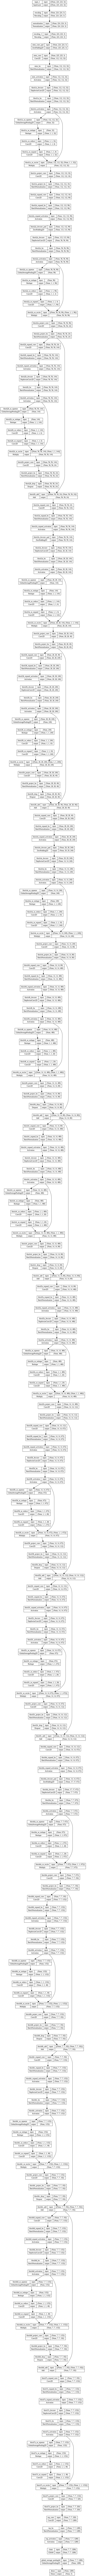

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.8 MB/s eta 0:00:00


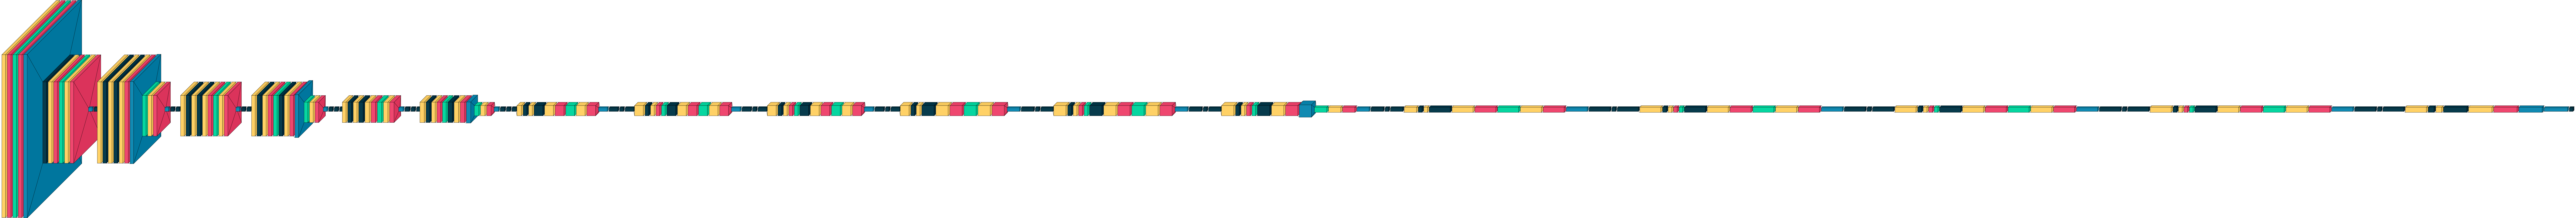

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
model.fit(
    traindata,
    steps_per_epoch = traindata.samples // 32,
    epochs=10,  # You can adjust the number of epochs
    validation_data=validatedata,
    validation_steps=validatedata.samples // 32

)

Epoch 1/10
281/281 [==============================] - 2359s 8s/step - loss: 0.3607 - accuracy: 0.8848 - val_loss: 0.8002 - val_accuracy: 0.8000
Epoch 2/10
281/281 [==============================] - 78s 276ms/step - loss: 0.1657 - accuracy: 0.9504 - val_loss: 0.3151 - val_accuracy: 0.9062
Epoch 3/10
281/281 [==============================] - 78s 277ms/step - loss: 0.0774 - accuracy: 0.9753 - val_loss: 0.3330 - val_accuracy: 0.9406
Epoch 4/10
281/281 [==============================] - 79s 280ms/step - loss: 0.0769 - accuracy: 0.9765 - val_loss: 0.2222 - val_accuracy: 0.9312
Epoch 5/10
281/281 [==============================] - 79s 282ms/step - loss: 0.0594 - accuracy: 0.9816 - val_loss: 0.2194 - val_accuracy: 0.9438
Epoch 6/10
281/281 [==============================] - 80s 283ms/step - loss: 0.0431 - accuracy: 0.9865 - val_loss: 0.2903 - val_accuracy: 0.9281
Epoch 7/10
281/281 [==============================] - 80s 283ms/step - loss: 0.0429 - accuracy: 0.9864 - val_loss: 0.1025 - val_acc

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
evaluation = model.evaluate(testdata)
print("Loss: ",evaluation[0])
print("Accuracy: ",evaluation[1])

10/10 [==============================] - 81s 9s/step - loss: 0.2712 - accuracy: 0.9236
Loss:  0.27124035358428955
Accuracy:  0.9235668778419495


In [ ]:
model.save('cbam_transfer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("/content/drive/MyDrive/cbam_transfer")